# Progression
- used Prashant's algorithm to extract some epitheliums
- take a random point inside epithelium, start building squares around the point until any two corners are not touching epithelium
- shrink square dimensions into a rectangular patch until opposite corners are not either background or stroma
- sample 50 random points per tissue set to get average patch dimensions

### Notes
- only used "normal" tissues, only H&E since those are extracted well by Prashant
- 

In [18]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Importing Epithelium Extractions (Ran Prashant's Algo Separately)

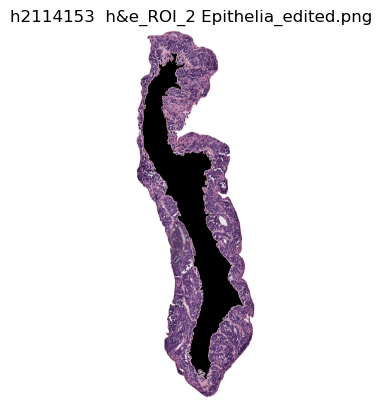

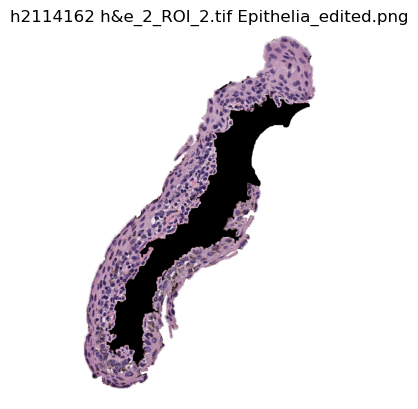

In [22]:
## import + display extractions

import os

folder_path = 'D:\\390scans\\background_white\\'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.tif'):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Load and display the image
        img = mpimg.imread(file_path)
        
        # Check if the image has an alpha channel and remove it if necessary
        if img.shape[2] == 4:
            img = img[:, :, :3]
        
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(filename)  # Show the filename as the title
        plt.show()


## Generating Squares

**First generated random point on epithelium, created non_black_white_mask to get coordinates**

Random point coordinates: (y, x) = [1403  209]


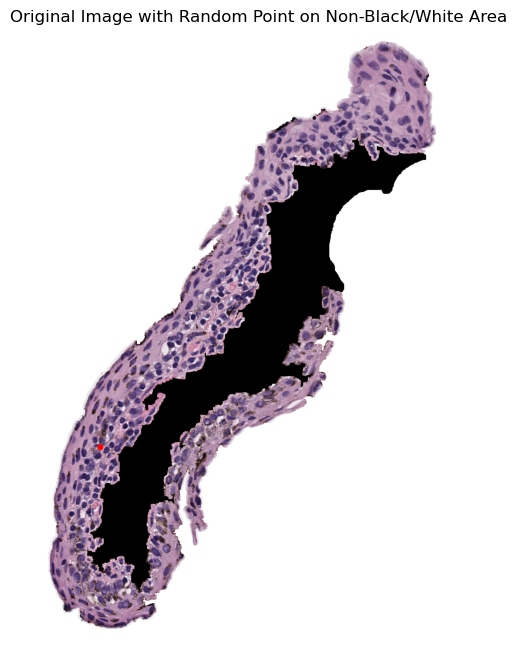

In [42]:
import cv2
import numpy as np
import random

image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png'
image = cv2.imread(image_path)

# Create a mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Find the coordinates of all non-black, non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Select a random point from these coordinates
random_point = random.choice(coordinates)

# Print the coordinates of the random point
print(f"Random point coordinates: (y, x) = {random_point}")

# Draw the random point on the original image (use a red dot for visibility)
image_with_point = image.copy()
cv2.circle(image_with_point, (random_point[1], random_point[0]), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

# Display the original image with the random point overlaid
plt.figure(figsize=(8, 8))
plt.title("Original Image with Random Point on Non-Black/White Area")
plt.imshow(cv2.cvtColor(image_with_point, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


**Drawing Squares until all 4 corners not in mask**

Random point coordinates: (y, x) = [1320 1021]


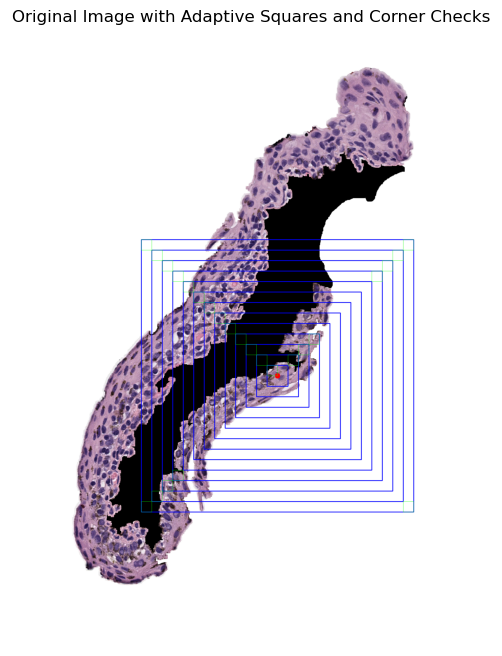

In [76]:
# Load the image
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png'
image = cv2.imread(image_path)

# Create a mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Find the coordinates of all non-black, non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Select a random point from these coordinates
random_point = random.choice(coordinates)
print(f"Random point coordinates: (y, x) = {random_point}")

# Draw squares of increasing size centered at the random point
image_with_squares = image.copy()
center_x, center_y = int(random_point[1]), int(random_point[0])

# Define initial square size and increment
initial_size = 40
corner_size = initial_size 
num_squares_drawn = 0

# Draw the random point on the image
cv2.circle(image_with_squares, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

while True:
    # Calculate the current square's size
    size = initial_size * (num_squares_drawn + 1)
    
    # Calculate the top-left and bottom-right coordinates of the square
    top_left = (center_x - size, center_y - size)
    bottom_right = (center_x + size, center_y + size)

    # Draw the main square on the image
    cv2.rectangle(image_with_squares, top_left, bottom_right, (255, 0, 0), 2)  # Red square
    
    # Check the 20x20 regions at each corner of the square
    corner_checks = [
        (int(top_left[1]), int(top_left[0])),  # Top-left corner
        (int(top_left[1]), int(bottom_right[0] - corner_size)),  # Top-right corner
        (int(bottom_right[1] - corner_size), int(top_left[0])),  # Bottom-left corner
        (int(bottom_right[1] - corner_size), int(bottom_right[0] - corner_size))  # Bottom-right corner
    ]
    
    # Flag to determine if all corners are outside the mask
    all_corners_outside = True

    # Check each corner
    for (corner_y, corner_x) in corner_checks:
        # Ensure the region is within the image bounds
        if corner_y < 0 or corner_x < 0 or corner_y + corner_size > image.shape[0] or corner_x + corner_size > image.shape[1]:
            continue  # Skip if the corner is out of bounds
        
        # Extract the 20x20 region in the mask at this corner
        corner_region = non_black_white_mask[corner_y:corner_y + corner_size, corner_x:corner_x + corner_size]
        
        # Draw the corner square on the image for visualization (use green color)
        cv2.rectangle(image_with_squares, (corner_x, corner_y), (corner_x + corner_size, corner_y + corner_size), (0, 255, 0), 1)  # Green square
        
        # If any pixels in the corner region are non-black, set all_corners_outside to False
        if np.any(corner_region):
            all_corners_outside = False
            break  # Stop checking further corners as we only need one inside the mask to continue

    # If all corners are outside the mask, break the loop
    if all_corners_outside:
        break

    # Increment the number of squares drawn
    num_squares_drawn += 1

# Display the image with the squares overlaid
plt.figure(figsize=(8, 8))
plt.title("Original Image with Adaptive Squares and Corner Checks")
plt.imshow(cv2.cvtColor(image_with_squares, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


**Seems a bit overkill, changed it to draw squares until any pair of opposite corners were not in the mask**

Random points coordinates: [(1589, 655), (394, 1184), (1852, 593), (1846, 268), (364, 1452)]


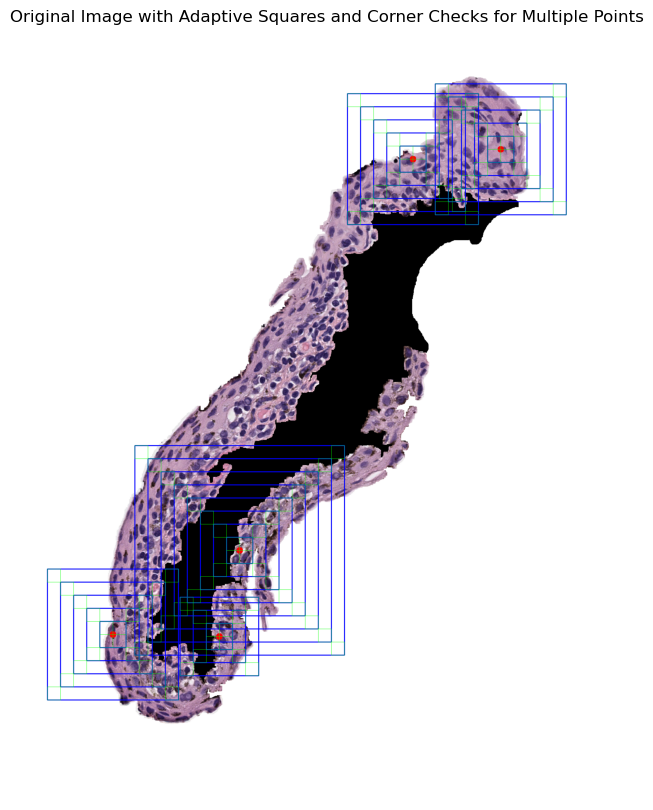

In [74]:
# Load the image
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png'
image = cv2.imread(image_path)

# Create a mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Find the coordinates of all non-black, non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Select 5 random points from these coordinates
random_points = [random.choice(coordinates) for _ in range(5)]
print(f"Random points coordinates: {[(p[0], p[1]) for p in random_points]}")

# Copy the original image to draw squares for each random point
image_with_squares = image.copy()

# Parameters for square size and corner checking
initial_size = 40
corner_size = initial_size  

# Process each random point
for random_point in random_points:
    center_x, center_y = int(random_point[1]), int(random_point[0])

    # Draw the random point on the image
    cv2.circle(image_with_squares, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    num_squares_drawn = 0

    while True:
        # Calculate the current square's size
        size = initial_size * (num_squares_drawn + 1)
        
        # Calculate the top-left and bottom-right coordinates of the square
        top_left = (center_x - size, center_y - size)
        bottom_right = (center_x + size, center_y + size)

        # Draw the main square on the image
        cv2.rectangle(image_with_squares, top_left, bottom_right, (255, 0, 0), 2)  # Red square
        
        # Define the corners
        corner_checks = {
            "top_left": (int(top_left[1]), int(top_left[0])),  # Top-left corner
            "top_right": (int(top_left[1]), int(bottom_right[0] - corner_size)),  # Top-right corner
            "bottom_left": (int(bottom_right[1] - corner_size), int(top_left[0])),  # Bottom-left corner
            "bottom_right": (int(bottom_right[1] - corner_size), int(bottom_right[0] - corner_size))  # Bottom-right corner
        }
        
        # Flags to track if opposite corners are outside the mask
        top_left_outside = False
        top_right_outside = False
        bottom_left_outside = False
        bottom_right_outside = False

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + corner_size > image.shape[0] or corner_x + corner_size > image.shape[1]:
                if corner_name == "top_left":
                    top_left_outside = True
                elif corner_name == "top_right":
                    top_right_outside = True
                elif corner_name == "bottom_left":
                    bottom_left_outside = True
                elif corner_name == "bottom_right":
                    bottom_right_outside = True
                continue  # Skip further checks if corner is out of bounds

            # Extract the 20x20 region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + corner_size, corner_x:corner_x + corner_size]
            
            # Draw the corner square on the image for visualization (use green color)
            cv2.rectangle(image_with_squares, (corner_x, corner_y), (corner_x + corner_size, corner_y + corner_size), (0, 255, 0), 1)  # Green square
            
            # If all pixels in the corner region are black (value 0), mark this corner as outside the mask
            if not np.any(corner_region):
                if corner_name == "top_left":
                    top_left_outside = True
                elif corner_name == "top_right":
                    top_right_outside = True
                elif corner_name == "bottom_left":
                    bottom_left_outside = True
                elif corner_name == "bottom_right":
                    bottom_right_outside = True

        # Stop drawing squares if any two opposite corners are outside the mask
        if (top_left_outside and bottom_right_outside) or (top_right_outside and bottom_left_outside):
            break

        # Increment the number of squares drawn
        num_squares_drawn += 1

# Display the image with the squares overlaid
plt.figure(figsize=(10, 10))
plt.title("Original Image with Adaptive Squares and Corner Checks for Multiple Points")
plt.imshow(cv2.cvtColor(image_with_squares, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

**Better, but still not as efficient as could be, exemplified by the squares drawn around the third lowest point.**
- Changed it so any two corners just have to be out of the mask, not necessarily two opposites

Random points coordinates: [(1176, 493), (777, 827), (1887, 308), (1521, 463), (1330, 861)]


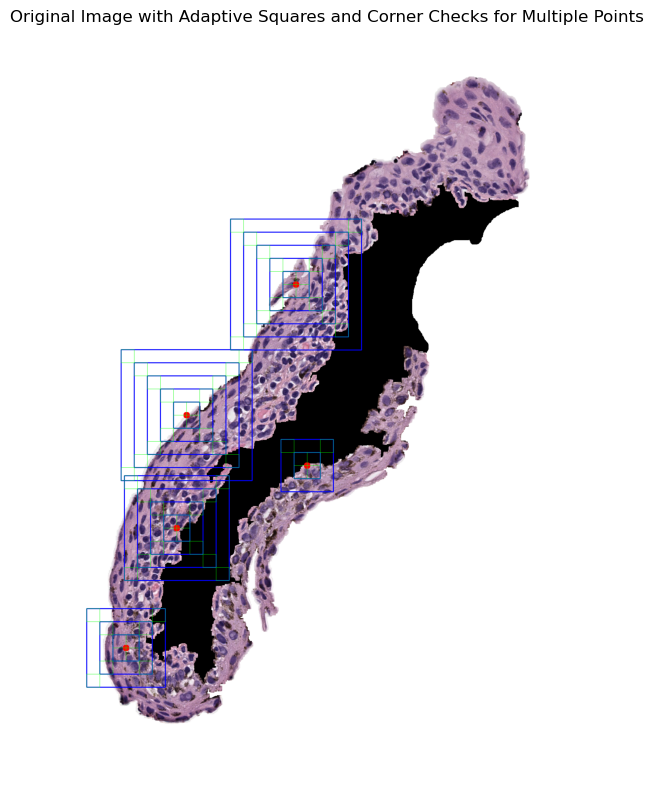

In [75]:
# Load the image
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

# Create a mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Find the coordinates of all non-black, non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Select 5 random points from these coordinates
random_points = [random.choice(coordinates) for _ in range(5)]
print(f"Random points coordinates: {[(p[0], p[1]) for p in random_points]}")

# Copy the original image to draw squares for each random point
image_with_squares = image.copy()

# Parameters for square size and corner checking
initial_size = 40
corner_size = 40  

# Process each random point
for random_point in random_points:
    center_x, center_y = int(random_point[1]), int(random_point[0])

    # Draw the random point on the image
    cv2.circle(image_with_squares, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    num_squares_drawn = 0

    while True:
        # Calculate the current square's size
        size = initial_size * (num_squares_drawn + 1)
        
        # Calculate the top-left and bottom-right coordinates of the square
        top_left = (center_x - size, center_y - size)
        bottom_right = (center_x + size, center_y + size)

        # Draw the main square on the image
        cv2.rectangle(image_with_squares, top_left, bottom_right, (255, 0, 0), 2)  # Red square
        
        # Define the regions at each corner of the square
        corner_checks = {
            "top_left": (int(top_left[1]), int(top_left[0])),  # Top-left corner
            "top_right": (int(top_left[1]), int(bottom_right[0] - corner_size)),  # Top-right corner
            "bottom_left": (int(bottom_right[1] - corner_size), int(top_left[0])),  # Bottom-left corner
            "bottom_right": (int(bottom_right[1] - corner_size), int(bottom_right[0] - corner_size))  # Bottom-right corner
        }
        
        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + corner_size > image.shape[0] or corner_x + corner_size > image.shape[1]:
                corners_outside_count += 1
                continue  # Skip further checks if corner is out of bounds

            # Extract the 20x20 region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + corner_size, corner_x:corner_x + corner_size]
            
            # Draw the corner square on the image for visualization (use green color)
            cv2.rectangle(image_with_squares, (corner_x, corner_y), (corner_x + corner_size, corner_y + corner_size), (0, 255, 0), 1)  # Green square
            
            # If all pixels in the corner region are black (value 0), mark this corner as outside the mask
            if not np.any(corner_region):
                corners_outside_count += 1

            # Stop checking if we already have two corners outside
            if corners_outside_count >= 2:
                break

        # Stop drawing squares if at least two corners are outside the mask
        if corners_outside_count >= 2:
            break

        # Increment the number of squares drawn
        num_squares_drawn += 1

# Display the image with the squares overlaid
plt.figure(figsize=(10, 10))
plt.title("Original Image with Adaptive Squares and Corner Checks for Multiple Points")
plt.imshow(cv2.cvtColor(image_with_squares, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


**Works more efficiently but might run into problems like the right most point where both valid corners are in one space (background or stroma) and you wouldn't be able to see the other.**
- Added condition that black/white color must be seen within area of largest square

Random points coordinates: [(1468, 357), (406, 1275), (1467, 793), (984, 800), (920, 771)]


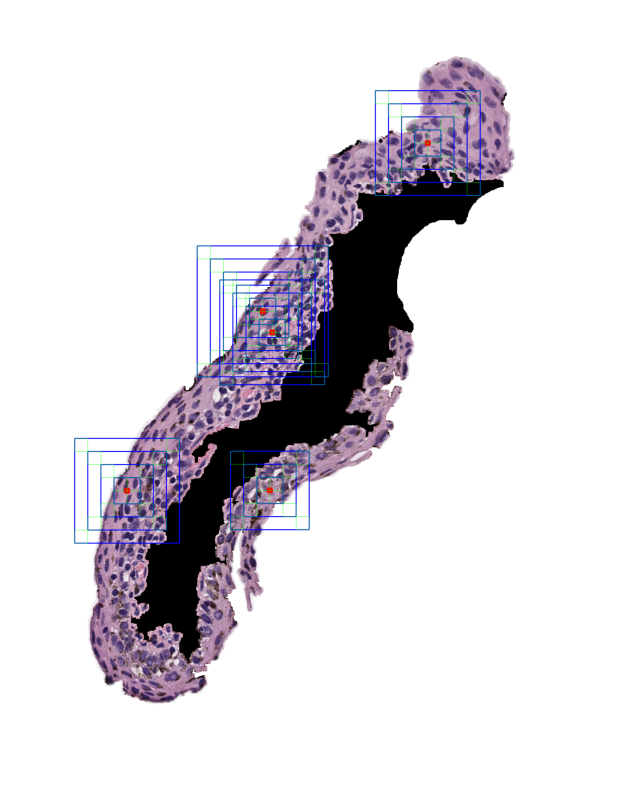

In [82]:
# Load the image
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

# Create a mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Find the coordinates of all non-black, non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Select 5 random points from these coordinates
random_points = [random.choice(coordinates) for _ in range(5)]
print(f"Random points coordinates: {[(p[0], p[1]) for p in random_points]}")

# Copy the original image to draw squares for each random point
image_with_squares = image.copy()

# Parameters for square size and corner checking
initial_size = 40
corner_size = initial_size

# Process each random point
for random_point in random_points:
    center_x, center_y = int(random_point[1]), int(random_point[0])

    # Draw the random point on the image
    cv2.circle(image_with_squares, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    num_squares_drawn = 0

    while True:
        # Calculate the current square's size
        size = initial_size * (num_squares_drawn + 1)
        
        # Calculate the top-left and bottom-right coordinates of the square
        top_left = (center_x - size, center_y - size)
        bottom_right = (center_x + size, center_y + size)

        # Draw the main square on the image
        cv2.rectangle(image_with_squares, top_left, bottom_right, (255, 0, 0), 2)  # Red square
        
        # Define the regions at each corner of the square
        corner_checks = {
            "top_left": (int(top_left[1]), int(top_left[0])),  # Top-left corner
            "top_right": (int(top_left[1]), int(bottom_right[0] - corner_size)),  # Top-right corner
            "bottom_left": (int(bottom_right[1] - corner_size), int(top_left[0])),  # Bottom-left corner
            "bottom_right": (int(bottom_right[1] - corner_size), int(bottom_right[0] - corner_size))  # Bottom-right corner
        }
        
        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + corner_size > image.shape[0] or corner_x + corner_size > image.shape[1]:
                corners_outside_count += 1
                continue  # Skip further checks if corner is out of bounds

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + corner_size, corner_x:corner_x + corner_size]
            
            # Draw the corner square on the image for visualization (use green color)
            cv2.rectangle(image_with_squares, (corner_x, corner_y), (corner_x + corner_size, corner_y + corner_size), (0, 255, 0), 1)  # Green square
            
            # If all pixels in the corner region are black (value 0), mark this corner as outside the mask
            if not np.any(corner_region):
                corners_outside_count += 1

            # Stop checking if we already have two corners outside
            if corners_outside_count >= 2:
                break

        # Stop drawing squares if at least two corners are outside the mask
        if corners_outside_count >= 2:
            # Check if the square area contains both black and white pixels
            square_region = image[max(0, top_left[1]):min(image.shape[0], bottom_right[1]),
                                  max(0, top_left[0]):min(image.shape[1], bottom_right[0])]

            # Check for black and white pixels within the square region
            contains_black = np.any(np.all(square_region == [0, 0, 0], axis=-1))
            contains_white = np.any(np.all(square_region == [255, 255, 255], axis=-1))

            # Only break if the square contains both black and white pixels
            if contains_black and contains_white:
                break

        # Increment the number of squares drawn
        num_squares_drawn += 1

# Display the image with the squares overlaid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_squares, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Shrinking Squares

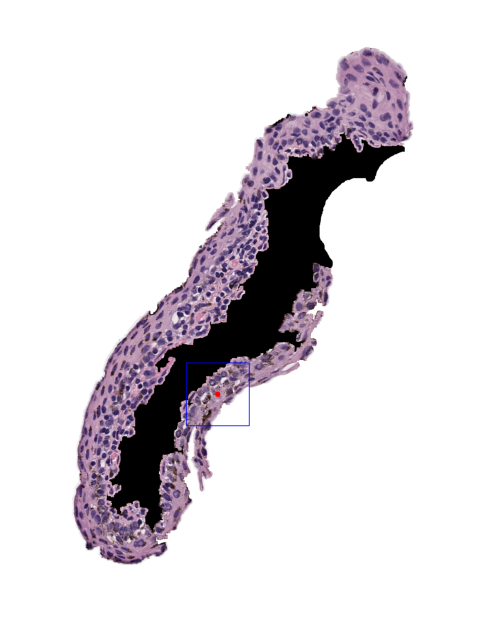

In [83]:
# Load the original image
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

# Define the target point and square parameters
target_point = (793, 1467)  # (x, y) format for OpenCV
square_size = 40 * 3  # Since this is the third square drawn, and initial size was 40
center_x, center_y = target_point

# Calculate the top-left and bottom-right coordinates of the third square
top_left = (center_x - square_size, center_y - square_size)
bottom_right = (center_x + square_size, center_y + square_size)

# Draw the largest square on the image
image_with_largest_square = image.copy()
cv2.rectangle(image_with_largest_square, top_left, bottom_right, (255, 0, 0), 2)  # Red square

# Draw the target point as a red dot
cv2.circle(image_with_largest_square, target_point, radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_largest_square, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


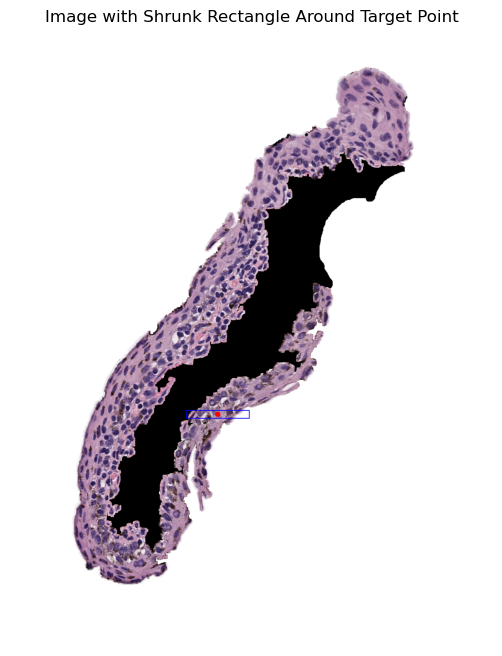

In [88]:
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

# Set initial square coordinates and size based on the target point
center_x, center_y = 793, 1467  # Point from your example, (x, y) format for OpenCV
initial_square_size = 40 * 3  # The third square as mentioned

# Calculate the top-left and bottom-right coordinates of the initial square
top = center_y - initial_square_size
bottom = center_y + initial_square_size
left = center_x - initial_square_size
right = center_x + initial_square_size

# Function to check if the rectangle area contains black, white, and mask pixels
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Shrink the top and bottom edges
while (bottom - top) > 30:  # Stop if height of the rectangle is <= 20 pixels
    # Extract the current region
    current_region = image[top:bottom, left:right]
    
    # Check if the region still contains black, white, and mask pixels
    if not contains_black_white_mask(current_region):
        break  # Stop if any of the required pixel types is missing
    
    # Move the top and bottom edges inward
    top += 1  # Move top edge down
    bottom -= 1  # Move bottom edge up

# Draw the resulting rectangle on a copy of the image
image_with_shrunk_rectangle = image.copy()
cv2.rectangle(image_with_shrunk_rectangle, (left, top), (right, bottom), (255, 0, 0), 2)  # Red rectangle
cv2.circle(image_with_shrunk_rectangle, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot for the point

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_shrunk_rectangle, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


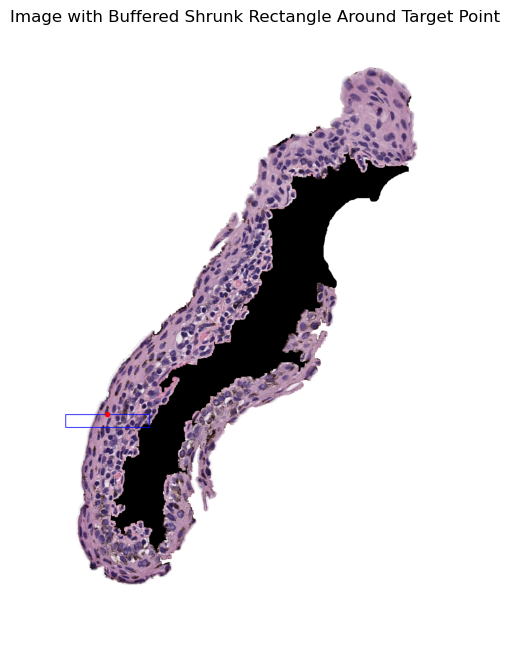

In [98]:
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

# Set initial square coordinates and size based on the target point
center_x, center_y = 357, 1468  # Point from your example, (x, y) format for OpenCV
initial_square_size = 40 * 4  # The third square as mentioned

# Calculate the top-left and bottom-right coordinates of the initial square
top = center_y - initial_square_size
bottom = center_y + initial_square_size
left = center_x - initial_square_size
right = center_x + initial_square_size

# Function to check if the rectangle area contains black, white, and mask pixels
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Flags to control whether each edge can continue moving
can_shrink_top = True
can_shrink_bottom = True

# Shrink the top and bottom edges independently
while (bottom - top) > 20:  # Stop if height of the rectangle is <= 20 pixels
    if can_shrink_top:
        # Move the top edge down by 1 pixel
        top += 1
        current_region = image[top:bottom, left:right]
        # Check if the region still contains black, white, and mask pixels
        if not contains_black_white_mask(current_region):
            # Revert the move and stop further movement of the top edge
            top -= 1
            can_shrink_top = False
    
    if can_shrink_bottom:
        # Move the bottom edge up by 1 pixel
        bottom -= 1
        current_region = image[top:bottom, left:right]
        # Check if the region still contains black, white, and mask pixels
        if not contains_black_white_mask(current_region):
            # Revert the move and stop further movement of the bottom edge
            bottom += 1
            can_shrink_bottom = False
    
    # Check if the center point is still within the rectangle; if not, break the loop
    if not (top < center_y < bottom):
        break

    # Break if both edges can no longer shrink
    if not can_shrink_top and not can_shrink_bottom:
        break

# Add a buffer of 10 pixels to the top or bottom if shrinking was stopped for that edge
if not can_shrink_top:
    top = max(0, top - 10)  # Ensure top does not go out of bounds
if not can_shrink_bottom:
    bottom = min(image.shape[0], bottom + 10)  # Ensure bottom does not go out of bounds

# Draw the resulting rectangle on a copy of the image
image_with_shrunk_rectangle = image.copy()
cv2.rectangle(image_with_shrunk_rectangle, (left, top), (right, bottom), (255, 0, 0), 2)  # Red rectangle
cv2.circle(image_with_shrunk_rectangle, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot for the point

# Display the result
plt.figure(figsize=(8, 8))
plt.title("Image with Buffered Shrunk Rectangle Around Target Point")
plt.imshow(cv2.cvtColor(image_with_shrunk_rectangle, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


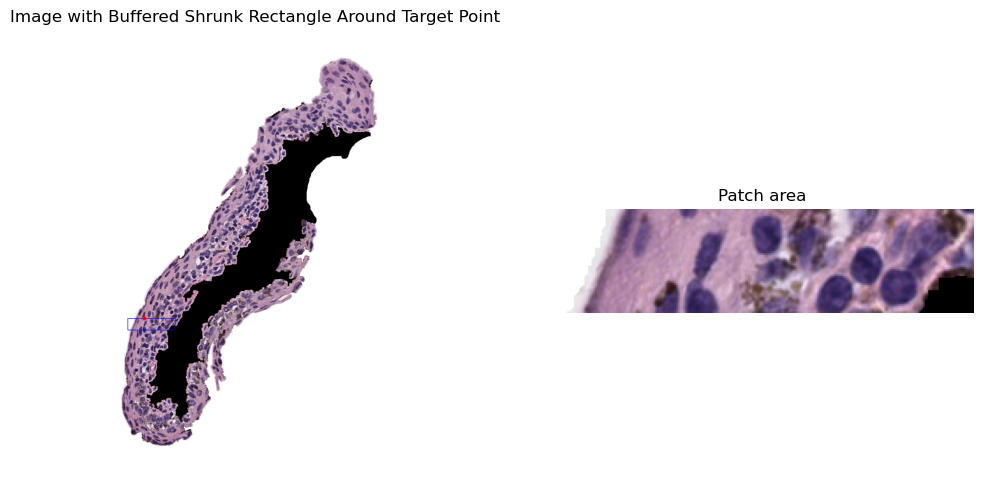

Final rectangle dimensions: Width = 240 pixels, Height = 59 pixels


In [109]:
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

# Set initial square coordinates and size based on the target point
center_x, center_y = 357, 1468  # Point from your example, (x, y) format for OpenCV
initial_square_size = 40 * 4  # The third square as mentioned

# Calculate the top-left and bottom-right coordinates of the initial square
top = center_y - initial_square_size
bottom = center_y + initial_square_size
left = center_x - initial_square_size
right = center_x + initial_square_size

# Function to check if the rectangle area contains black, white, and mask pixels
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Step 1: Shrink the top and bottom edges to the fullest extent
can_shrink_top = True
can_shrink_bottom = True

while (bottom - top) > 20:  # Stop if height of the rectangle is <= 20 pixels
    if can_shrink_top:
        # Move the top edge down by 1 pixel
        top += 1
        current_region = image[top:bottom, left:right]
        # Check if the region still contains black, white, and mask pixels
        if not contains_black_white_mask(current_region):
            # Revert the move and stop further movement of the top edge
            top -= 1
            can_shrink_top = False
    
    if can_shrink_bottom:
        # Move the bottom edge up by 1 pixel
        bottom -= 1
        current_region = image[top:bottom, left:right]
        # Check if the region still contains black, white, and mask pixels
        if not contains_black_white_mask(current_region):
            # Revert the move and stop further movement of the bottom edge
            bottom += 1
            can_shrink_bottom = False

    # Check if the center point is still within the rectangle; if not, break the loop
    if not (top < center_y < bottom):
        break

    # Break if both edges can no longer shrink
    if not can_shrink_top and not can_shrink_bottom:
        break

# Add a buffer of 10 pixels to the top or bottom if shrinking was stopped for that edge
if not can_shrink_top:
    top = max(0, top - 20)  # Ensure top does not go out of bounds
if not can_shrink_bottom:
    bottom = min(image.shape[0], bottom + 20)  # Ensure bottom does not go out of bounds

# Step 2: Shrink the left and right edges to the fullest extent
can_shrink_left = True
can_shrink_right = True

while can_shrink_left or can_shrink_right:
    if can_shrink_left:
        # Move the left edge right by 1 pixel
        left += 1
        current_region = image[top:bottom, left:right]
        # Check if the region still contains black, white, and mask pixels
        if not contains_black_white_mask(current_region):
            # Revert the move and stop further movement of the left edge
            left -= 1
            can_shrink_left = False

    if can_shrink_right:
        # Move the right edge left by 1 pixel
        right -= 1
        current_region = image[top:bottom, left:right]
        # Check if the region still contains black, white, and mask pixels
        if not contains_black_white_mask(current_region):
            # Revert the move and stop further movement of the right edge
            right += 1
            can_shrink_right = False

    # Check if the center point is still within the rectangle; if not, break the loop
    if not (left < center_x < right):
        break

# Add a buffer of 10 pixels to the left or right if shrinking was stopped for that edge
if not can_shrink_left:
    left = max(0, left - 30)  # Ensure left does not go out of bounds
if not can_shrink_right:
    right = min(image.shape[1], right + 30)  # Ensure right does not go out of bounds

# Draw the resulting rectangle on a copy of the image
image_with_shrunk_rectangle = image.copy()
cv2.rectangle(image_with_shrunk_rectangle, (left, top), (right, bottom), (255, 0, 0), 2)  # Red rectangle
cv2.circle(image_with_shrunk_rectangle, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot for the point

# Crop the area within the final rectangle
cropped_region = image[top:bottom, left:right]

# Display the result with the rectangle and the zoomed-in cropped region
plt.figure(figsize=(12, 6))

# Show the original image with the rectangle
plt.subplot(1, 2, 1)
plt.title("Image with Buffered Shrunk Rectangle Around Target Point")
plt.imshow(cv2.cvtColor(image_with_shrunk_rectangle, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Show the zoomed-in cropped region
plt.subplot(1, 2, 2)
plt.title("Patch area")
plt.imshow(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

# Print the dimensions of the final rectangle
final_width = right - left
final_height = bottom - top
print(f"Final rectangle dimensions: Width = {final_width} pixels, Height = {final_height} pixels")

## Final Patches with 5 Random Points

**full automation and combining full algo to be finished after class**

In [84]:
# Patch dimensions